In [13]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

from langchain_ollama.llms import OllamaLLM
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain
from tqdm import tqdm

import sys
import os

In [14]:
#FUNCIONES PERSONALIZADAS PARA LOS MODELOS
sys.path.append(os.path.abspath("../funciones"))

#IMPORAR FUNCIONES AUXILIARES PERSONALIZADAS DESDE EL MÓDULO
from funcionesEntrenamientoLLM import (
    cargar_datos_entrenamiento,
    imprimir_forma
)

In [15]:
#CARGA Y PREPARACIÓN DE DATOS DE ENTRENAMIENTO
X, y_reales = cargar_datos_entrenamiento()

shape, head = imprimir_forma(X)
print("Shape: ", shape)
head

Shape:  (1500,)


0    Cheesecake saludable sin azúcar y sin lactosa ...
1                 ser como ellas ♡♡\n  #HastaLosHuesos
2    Comida Real o , la clave para estar más sana, ...
3    Entre el cambio de hora y la bajada de las #te...
4       Hace mucho tiempo no sentía mi cuerpo tan frío
Name: tweet_text, dtype: object

In [16]:
# Inicializar modelo LLaMA3 vía Ollama
llm = OllamaLLM(model="llama3")

In [17]:
# Crear el prompt con few-shot
prompt = PromptTemplate.from_template("""
Eres un asistente experto en salud mental. Tu tarea es analizar tweets e indicar si muestran señales de un posible trastorno alimenticio (como anorexia, bulimia, o similares).

Responde únicamente con "Sí" si el tweet indica un posible trastorno alimenticio, y con "No" si no lo indica.

Ejemplos:
Tweet: "no comí en todo el día y me siento bien" → Sí
Tweet: "me encanta comer con mis amigos los fines de semana" → No
Tweet: "me siento gorda incluso si no como nada" → Sí
Tweet: "hoy hice ejercicio y luego almorcé con mi familia" → No
Tweet: "ser como ellas ♡♡
  #hastaLoshuesos" → Sí
Tweet: "hoy #domingo os esperamos desde las 10:00 de la mañana para empezar el día con un buen desayuno.

también podéis reservar mesa para comer o cenar y disfrutar de nuestra carta o del menú fin de semana.
 980 56 99 34

#felizdomingo #restaurantealabros #zamora  #yum" → No

Ahora, clasifica el siguiente tweet, recuerda responder únicamente con dos letras en cada caso 'Sí' o 'No', sin explicaciones, como se muestra en los ejemplos. También recuerda que lo que recibes como input es únicamente el tweet y nada más que el tweet al que tienes que clasificar:
Tweet: "{tweet}" → 
""")

In [18]:
# Crear el pipeline
chain = LLMChain(prompt=prompt, llm=llm)

In [19]:
# Obtener predicciones
predicciones = []
for tweet in tqdm(X, desc="Clasificando tweets con LLaMA3"):
    result = chain.invoke({"tweet": tweet})
    answer = result['text'].strip().lower()
    if "Sí" in answer or "sí" in answer:
        predicciones.append(1)
    elif "No" in answer or "no" in answer:
        predicciones.append(0)
    else:
        print("Error en tweet:", result['text'])
        break  # debug en caso de error

Clasificando tweets con LLaMA3: 100%|██████████| 1500/1500 [04:01<00:00,  6.21it/s]


In [20]:
# Convertir las predicciones en un dataframe de pandas
y_preds = pd.DataFrame(predicciones, columns=['predicciones'])

In [21]:
print("Classification Report:")
print(classification_report(y_reales, y_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.51      0.67       696
           1       0.70      0.99      0.82       804

    accuracy                           0.77      1500
   macro avg       0.83      0.75      0.74      1500
weighted avg       0.82      0.77      0.75      1500



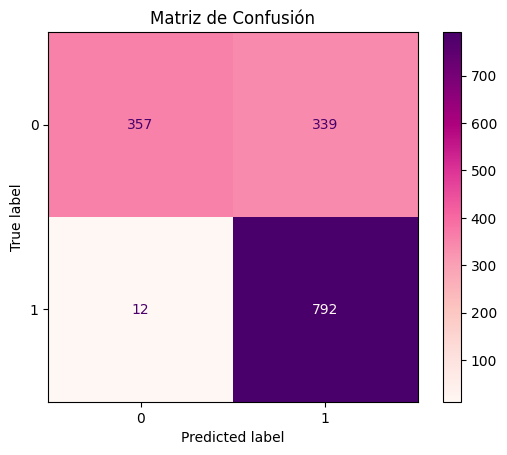

In [22]:
#MATRIZ DE CONFUSIÓN
cm = confusion_matrix(y_reales, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='RdPu')
plt.title("Matriz de Confusión")
plt.show()

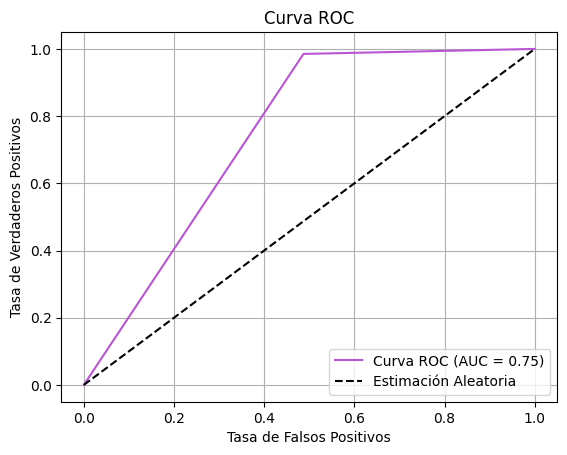

In [23]:
#CURVA ROC
fpr, tpr, thresholds = roc_curve(y_reales, y_preds)
auc_score = roc_auc_score(y_reales, y_preds)

plt.figure()
plt.plot(fpr, tpr, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [24]:
#MÉTRICAS TPR/FPR
TN, FP, FN, TP = cm.ravel()
FPR = 0.0 if FP + TN == 0.0 else FP / (FP + TN)
TPR = 0.0 if TP + FN == 0.0 else TP / (TP + FN)

# Mostrar métricas
print(f"AUC: {(auc_score * 100):.4f}")
print(f"TPR (Tasa de Positivos Verdaderos): {(TPR * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR * 100):.4f}")

AUC: 74.9003
TPR (Tasa de Positivos Verdaderos): 98.5075
FPR (Tasa de Falsos Positivos): 48.7069
